**Rede convolucional para identificação de células de tecido sanguíneo apartir de imagens de microscópio**

Tentativa com SKLEARN (Waldeyr 01-03-2021)

Inspirado (quase totalmente copiado) de https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Bibliotecas Python necessárias
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
# from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.data_utils import get_file

**Upload dos dados a partir de um arquivo .zip**





In [ ]:
# Criação de um diretório "dataset", o zip é colocado nesse dataset
os.makedirs("/content/datasets/", exist_ok=True)

In [ ]:
!unzip /content/datasets/blood_input_as_zip.zip

In [ ]:
class_names = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo']
nb_classes = len(class_names)
image_size = (150,150)

**Lendo dados descompactados a partir dos subdiretórios baixados**


In [ ]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/blood_input_as_zip/train/eosinofilo')
# Diretorio com imagens de validação de eosinofilo 
valid1 = os.path.join('/content/blood_input_as_zip/valid/eosinofilo')
# Diretorio com imagens de teste de eosinofilo 
test1 = os.path.join('/content/blood_input_as_zip/test/eosinofilo')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/blood_input_as_zip/train/linfocito')
# Diretorio com imagens de validação de linfocito 
valid2 = os.path.join('/content/blood_input_as_zip/valid/linfocito')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/blood_input_as_zip/test/linfocito')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/blood_input_as_zip/train/monocito')
# Diretorio com imagens de validação de monocito 
valid3 = os.path.join('/content/blood_input_as_zip/valid/monocito')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/blood_input_as_zip/test/monocito')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/blood_input_as_zip/train/neutrofilo')
# Diretorio com imagens de validação de neutrofilo 
valid4 = os.path.join('/content/blood_input_as_zip/valid/neutrofilo')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/blood_input_as_zip/test/neutrofilo')


print('total train eosinofilo:', len(os.listdir(train1)))
print('total valid eosinofilo:', len(os.listdir(valid1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
print('total valid linfocito:', len(os.listdir(valid2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
print('total valid monocito:', len(os.listdir(valid3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
print('total valid neutrofilo:', len(os.listdir(valid4)))
print('total test neutrofilo:', len(os.listdir(test4)))

## Normalização e Input dos dados

**Input dos dados**

In [ ]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset():
    datasets = ['/content/blood_input_as_zip/train/','/content/blood_input_as_zip/valid/', '/content/blood_input_as_zip/test/' ]
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['eosinofilo']: label = 0
            elif folder in ['linfocito']:  label = 1
            elif folder in ['monocito']:   label = 2
            elif folder in ['neutrofilo']: label = 3
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [ ]:
# Combinar todas as imagens originais em um único dataset
images, labels = loadDataset()

100%|██████████| 32/32 [00:00<00:00, 235.47it/s]


In [ ]:
# Observando as images após a normalização
plt.imshow(images[100])

In [ ]:
# Embaralhar os dados e separar novos conjuntos de  treinamento (80%), validação (10%) e teste (10%)
images, labels = shuffle(images, labels, random_state=10)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [ ]:
plt.imshow(train_images[2232])

In [ ]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Quantidade de imagens para treinamento: {}".format(n_train))
print("Quantidade de imagens para validação: {}".format(n_val))
print("Quantidade de imagens para teste: {}".format(n_test))

print("Formato das imagens de treinamento: {}".format(train_images.shape))
print("Labels das imagens de treinamento: {}".format(train_labels.shape))
print("Formato das imagens de validação: {}".format(val_images.shape))
print("Labels das imagens de validação: {}".format(val_labels.shape))
print("Formato das imagens de teste: {}".format(test_images.shape))
print("Labels das imagens de teste: {}".format(test_labels.shape))


Quantidade de imagens para treinamento: 2233
Quantidade de imagens para validação: 280
Quantidade de imagens para teste: 279
Formato das imagens de treinamento: (2233, 150, 150, 3)
Labels das imagens de treinamento: (2233,)
Formato das imagens de validação: (280, 150, 150, 3)
Labels das imagens de validação: (280,)
Formato das imagens de teste: (279, 150, 150, 3)
Labels das imagens de teste: (279,)


In [ ]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)


(2233, 150, 150, 3)
(279, 150, 150, 3)
(280, 150, 150, 3)


In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)



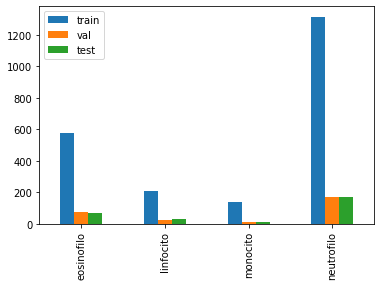

In [ ]:
pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

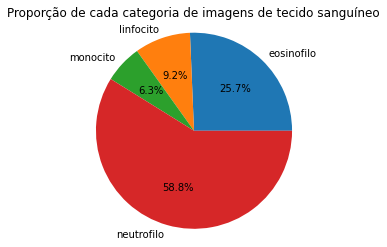

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção de cada categoria de imagens de tecido sanguíneo')
plt.show()

**Normalização dos dados**

In [ ]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [ ]:
# Mais uma verificação da img após a normalização
plt.imshow(train_images[2000])

In [ ]:
# Checagem com imagem aleatória
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

In [ ]:
# Checagem com exemplos de imagens de cada categoria
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

## Construção e treino do modelo 

In [ ]:
model = Sequential()
#Xception
'''
Conv2D(nº de featuremaps, tamanho do kernel(3,3), )
'''
# # Primeira camada concolucional
# model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
# model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Segunda camada concolucional
# model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
# model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Terceira camada concolucional
# model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
# model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Quarta camada concolucional
# model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
# model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.2))

# # Quinta camada concolucional
# model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
# model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.2))
'''Xception Model '''
# Primeira camada concolucional
model.add(Conv2D(32 , (3,3), padding = 'same', activation = 'relu', strides=(2, 2), input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
# Residual
model.add(Conv2D(128 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())

# Segunda camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))

# Residual
model.add(Conv2D(256 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())


# Terceira camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))

# Residual
model.add(Conv2D(728 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())

# Quarta camada concolucional
model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))
model.add(Dropout(0.2))

for i in range(8):
# Quinta camada concolucional
    model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(1024, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (1,1)))

model.add(SeparableConv2D(1536, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

model.add(SeparableConv2D(2048, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten(input_shape = (150,150,3)))

# Pesos camada dense
#pesos_camada_dense = model.layers[1].get_weights()[0]
#pesos_camada_dense_zerados = np.zeros((22500,1500))

# Vieses camada dense
#vieses_camada_dense = model.layers[1].get_weights()[1]
#vieses_camada_dense

# Zerando os pesos da camadas dense
#model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense])

model.add(Dense(units = 1024 , activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(0.3))


# Camada de saída
model.add(Dense(units = 4 , activation = 'softmax'))

# Compilação
model.compile(optimizer = "sgd" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
#model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='best_model_epoc_50.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 100, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Epoch 1/100
70/70 [==============================] - 19s 148ms/step - loss: 1.3224 - accuracy: 0.5639 - val_loss: 1.1560 - val_accuracy: 0.6107
Epoch 2/100
70/70 [==============================] - 7s 93ms/step - loss: 1.1598 - accuracy: 0.5885 - val_loss: 1.0613 - val_accuracy: 0.6107
Epoch 3/100
70/70 [==============================] - 6s 92ms/step - loss: 1.0931 - accuracy: 0.5940 - val_loss: 1.0337 - val_accuracy: 0.6107

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 4/100
70/70 [==============================] - 6s 88ms/step - loss: 1.0922 - accuracy: 0.5804 - val_loss: 1.0295 - val_accuracy: 0.6107
Epoch 5/100
70/70 [==============================] - 6s 89ms/step - loss: 1.0746 - accuracy: 0.5971 - val_loss: 1.0258 - val_accuracy: 0.6107

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
Epoch 6/100
70/70 [==============================] - 6s 89ms/step - loss: 1.0858 - accuracy: 0.5937 - val_loss: 1.0252 - val_a

# Gerando imagem da arquitetura

### Model plotting utilities

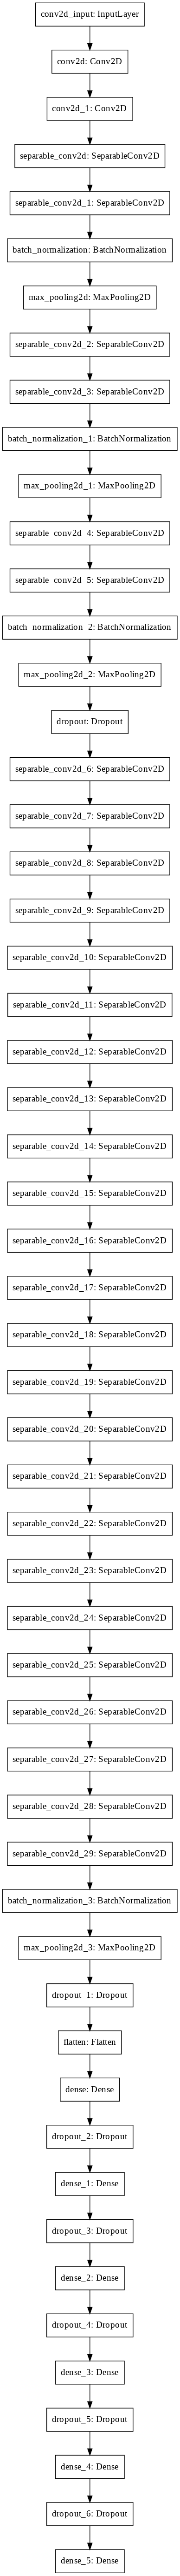

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_teste.png', show_shapes=True)

AssertionError: ignored

### VisualKeras

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont

In [ ]:
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf", 28)  # using comic sans is strictly prohibited!

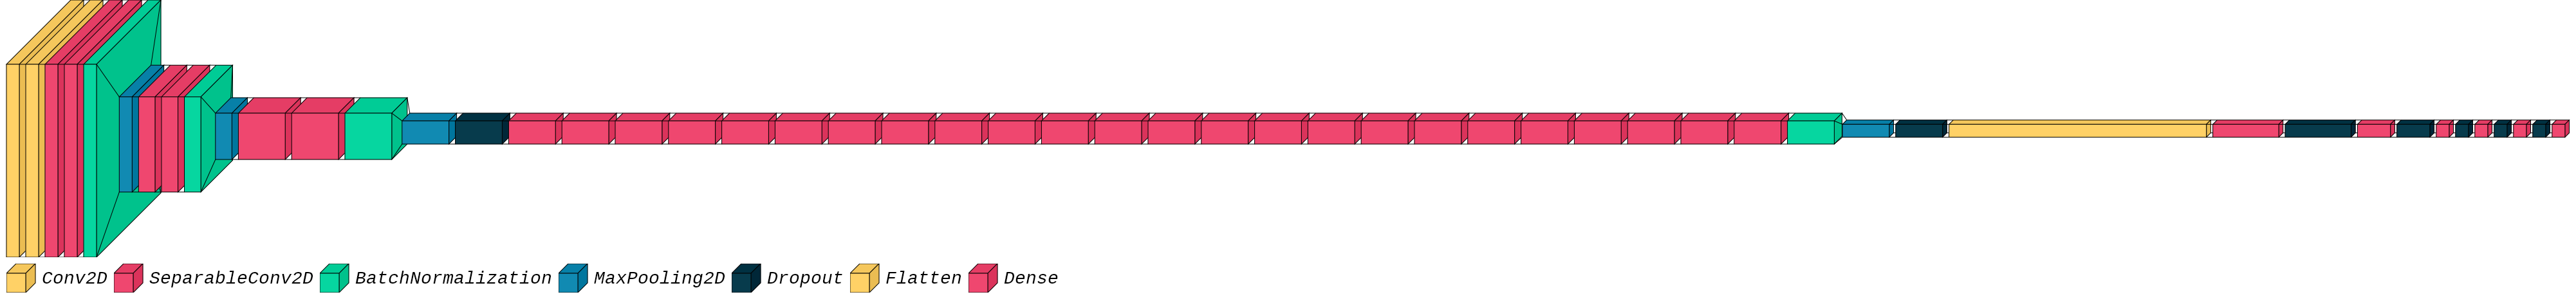

In [ ]:
visualkeras.layered_view(model,legend=True, font=font)

In [ ]:
# visualkeras.layered_view(model).show()
# visualkeras.layered_view(model, to_file='camadas_img1.png', legend=True, font=font)
# visualkeras.layered_view(model, to_file='camadas_img1.png').show()

### Sequential model in Keras -> ASCII

In [ ]:
!pip install keras_sequential_ascii
import keras_sequential_ascii

In [ ]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

### Neuron

In [ ]:
pip install netron

In [ ]:
model.save('best_model_epoc_50.hdf5')

In [ ]:
import netron
netron.start('best_model_epoc_50.hdf5')

### Quiver_engine

In [ ]:
 pip install git+git://github.com/keplr-io/quiver.git

In [ ]:
import quiver_engine
from quiver_engine import server

In [ ]:
quiver_engine.launch(model)

In [ ]:
pesos_camada_dense = model.layers[1].get_weights()[0]
pesos_camada_dense.shape

(3, 3, 16, 16)

In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

9/9 [==============================] - 0s 24ms/step - loss: 0.7977 - accuracy: 0.5950
Perda do modelo =  0.7976744174957275
Acurácia do modelo =  59.49820876121521 %


In [ ]:
# Obeservando os pesos
pesos_camada_dense = model.layers[1].get_weights()[0]
pesos_camada_dense.shape
# Reiniciando nossos pesos com zeros
# pesos_camada_dense_zerados = np.zeros((67500,1500))
# pesos_camada_dense

# # Vieses camada dense
# vieses_camada_dense = model.layers[1].get_weights()[1]
# vieses_camada_dense

SyntaxError: ignored

## Avaliação

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(100)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    plt.show()

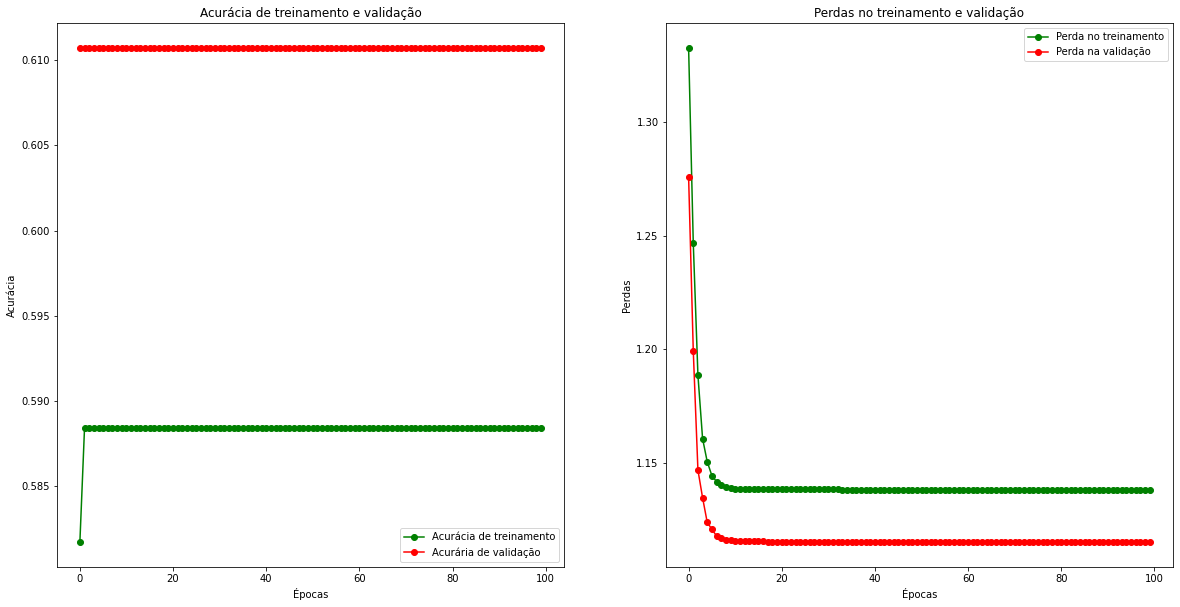

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history)


In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

9/9 [==============================] - 1s 130ms/step - loss: 1.1187 - accuracy: 0.6129
Perda do modelo =  1.1187405586242676
Acurácia do modelo =  61.29032373428345 %


In [ ]:
# Salvar o modelo
#model.save('BloodModel_20210708.h5') #Acurácia do modelo: 22.93%
# Aumento do número de epochs de 10 para 20
#model.save('best_model_epoc_20.hdf5') #Acurácia do modelo: 74.19%
# Aumento do número de epochs de 10 para 50
model.save('best_model_epoc_50.hdf5') #Acurácia do modelo: 67.025%


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0])

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['eosinófilo (Class 0)', 'linfócito (Class 1)', 'monócito (Class 2)', 'neutrófilo (Class 3)']))

                      precision    recall  f1-score   support

eosinófilo (Class 0)       0.46      0.64      0.53        67
 linfócito (Class 1)       0.00      0.00      0.00        28
  monócito (Class 2)       0.00      0.00      0.00        18
neutrófilo (Class 3)       0.84      0.94      0.89       166

            accuracy                           0.71       279
           macro avg       0.33      0.40      0.36       279
        weighted avg       0.61      0.71      0.66       279



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,43,0,0,24
1,24,0,0,4
2,17,0,0,1
3,10,0,0,156


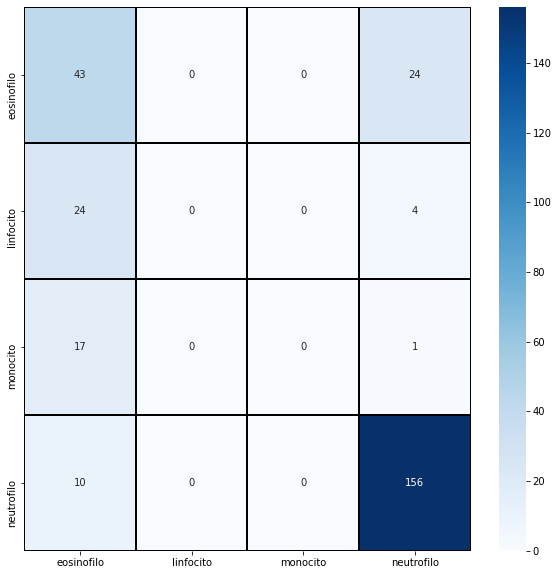

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)